# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

3) Построение softmax-классификатора

Вариант 4: задания 1 и 3 на наборе данных MNIST

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [38]:
import random
import numpy as np
import matplotlib.pyplot as plt
import statistics
from statistics import mode
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import load_digits
import itertools


%matplotlib inline
plt.rcParams['figure.figsize'] = (1.0, 1.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.


MNIST
sklearn.datasets import load_digits
digits = load_digits()

In [16]:
# Загрузим датасет
digits = load_digits()

1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



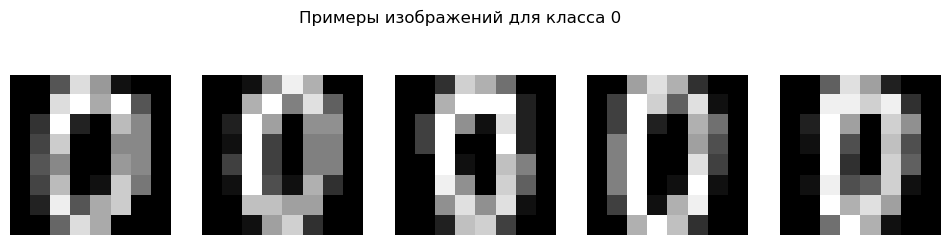

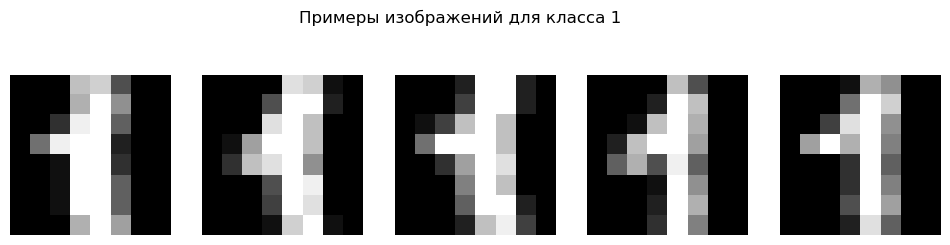

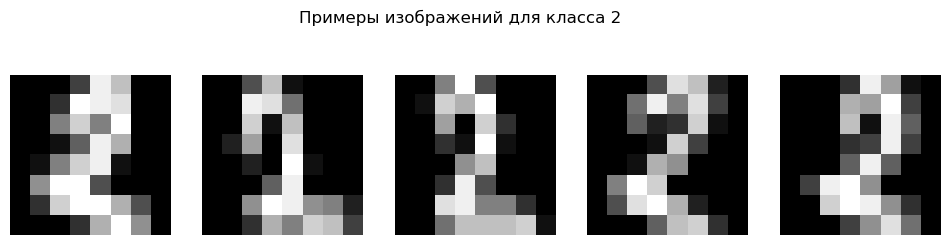

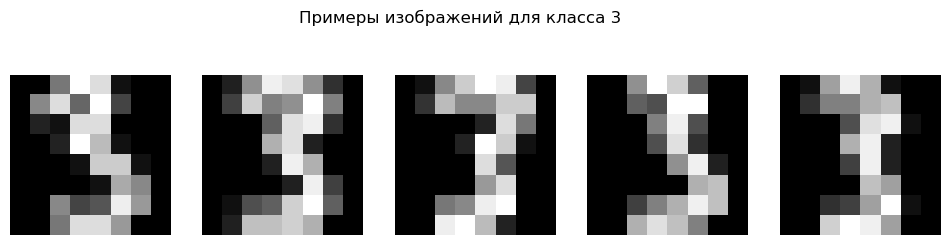

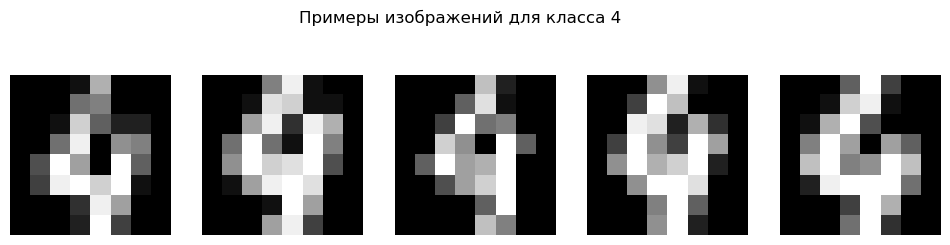

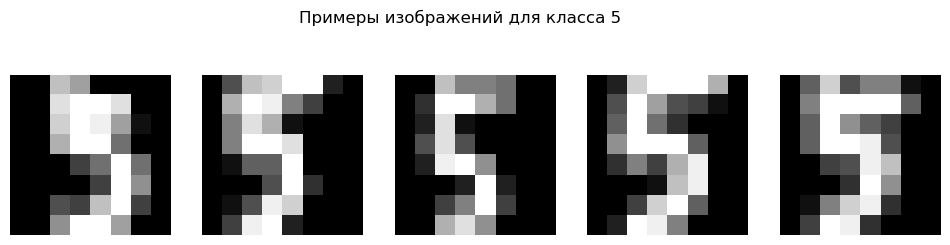

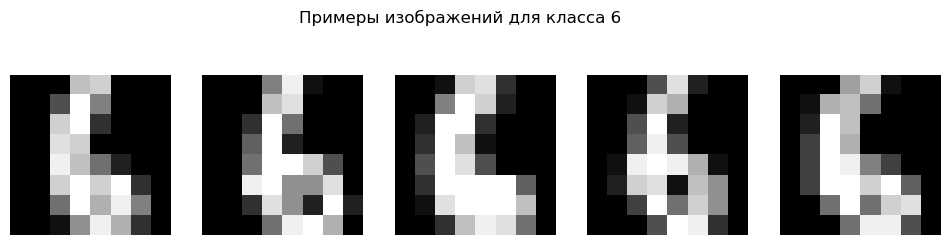

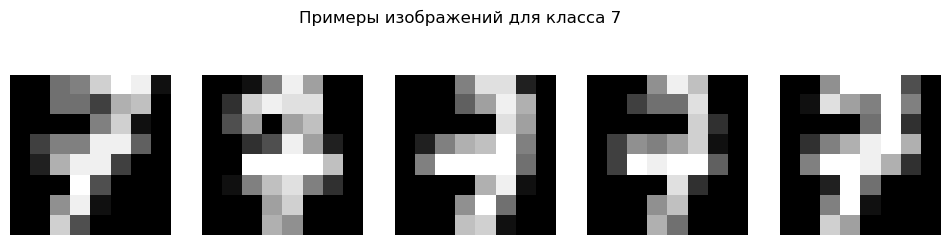

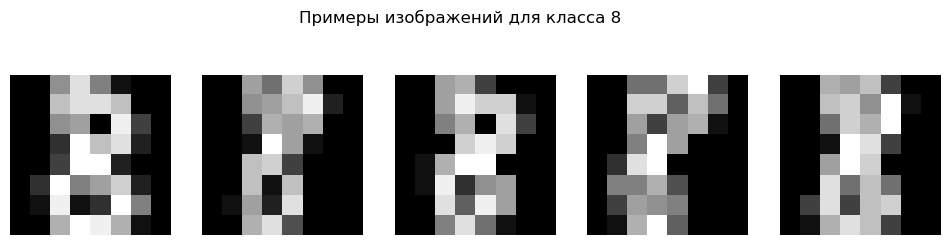

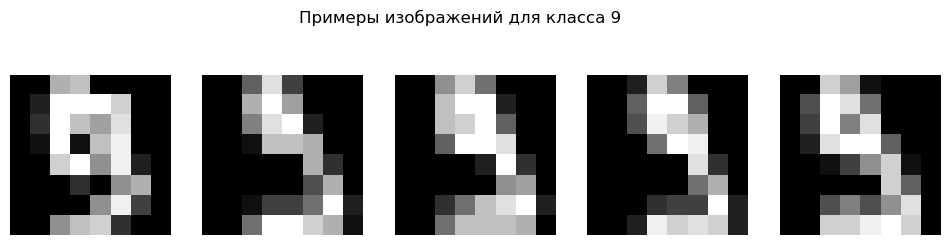

In [17]:
# Создание словаря меток с соответствующими индексами
class_indices = {i: [] for i in range(len(set(digits.target)))}
for i, label in enumerate(digits.target):
    class_indices[int(label)].append(i)

# Отображение примеров изображений для каждого класса
for class_index in class_indices:
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    fig.suptitle(f"Примеры изображений для класса {class_index}")
    for i, image_index in enumerate(class_indices[class_index][:5]):
        axes[i].imshow(digits.images[image_index].reshape(8, 8), cmap='gray')
        axes[i].axis('off')
    plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив.

In [18]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

# Преобразование изображений в одномерные массивы
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Вывод размеров полученных выборок
print("Размеры обучающей выборки:", X_train_flat.shape)
print("Размеры тестовой выборки:", X_test_flat.shape)

Размеры обучающей выборки: (1437, 64)
Размеры тестовой выборки: (360, 64)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке.

In [19]:
class KNearestNeighbor:
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _predict(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        y_pred = np.zeros(num_test, dtype=int)
        for i in range(num_test):
            # Calculate Euclidean distances
            distances = np.sqrt(np.sum(np.square(self.X_train - X[i]), axis=1))

            # Get the indices of the k closest neighbors
            closest_indices = np.argsort(distances)[:self.k]

            # Get the labels of the closest neighbors
            closest_labels = self.y_train[closest_indices]

            # Calculate the most common label
            y_pred[i] = mode(closest_labels)

        return y_pred

    def predict(self, X):
        return self._predict(X)

    def get_params(self, deep=True):
        return {"k": self.k}

In [20]:
# Оптимизированная версия
classifier = KNearestNeighbor(k=1)
classifier.fit(X_train_flat, y_train.astype(int))

1.5 Выполните классификацию на тестовой выборке

In [21]:
# Предсказание меток для тестового набора
y_pred = classifier.predict(X_test_flat)

# Оптимизированная версия
accuracy = np.mean(y_pred == y_test)
print(f"Точность: {accuracy:.2%}")

Точность: 97.78%


1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки.


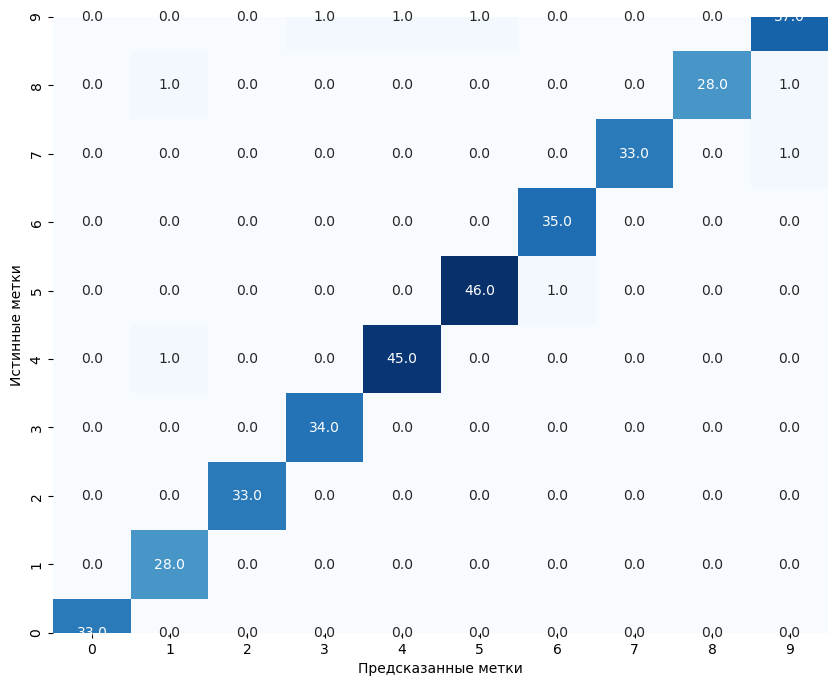

In [22]:
# Построение матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".1f", cmap="Blues", cbar=False, yticklabels=digits.target_names)
plt.xlabel("Предсказанные метки")
plt.ylabel("Истинные метки")
bottom, top = plt.ylim()
plt.ylim(top + 0.5, bottom - 0.5)
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [23]:
# Расчет метрик оценки
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.93      1.00      0.97        28
           2       1.00      1.00      1.00        33
           3       0.97      1.00      0.99        34
           4       0.98      0.98      0.98        46
           5       0.98      0.98      0.98        47
           6       0.97      1.00      0.99        35
           7       1.00      0.97      0.99        34
           8       1.00      0.93      0.97        30
           9       0.95      0.93      0.94        40

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

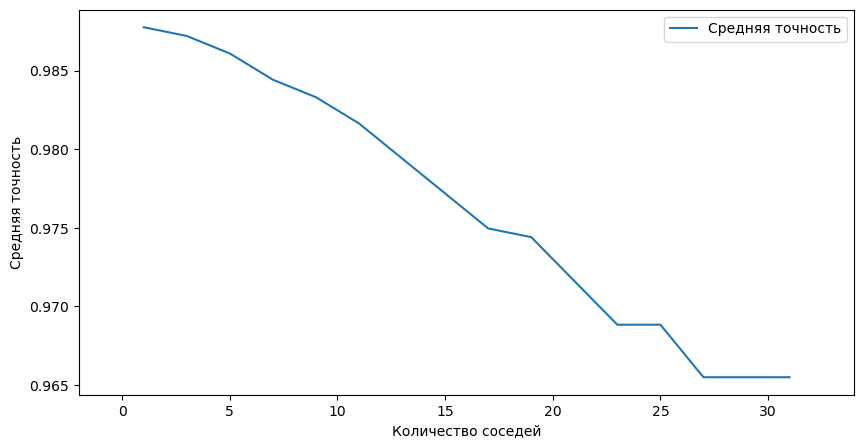

Лучшее значение k: 1


In [24]:
#Оптимизированный кросс-валидационный процесс
list_mean_accuracy = list()
for k in range(1, 32, 2):
    cv_accuracies = []
    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=7575)
    for i, (train_index, test_index) in enumerate(kf.split(digits.data, digits.target)):
        X_train, X_test = digits.data[train_index], digits.data[test_index]
        y_train, y_test = digits.target[train_index], digits.target[test_index]

        classifier = KNearestNeighbor(k=k)
        classifier.fit(X_train, y_train)

        preds = classifier.predict(X_test)
        acc = accuracy_score(y_test, preds)
        cv_accuracies.append(acc)
    list_mean_accuracy.append(np.mean(cv_accuracies))
# Оптимизированная версия
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(list(range(1, 32, 2)), list(list_mean_accuracy), label='Средняя точность')
plt.xlabel("Количество соседей")
plt.ylabel("Средняя точность")
ax.margins(x=0.1)
plt.legend(loc='best')
plt.show()
print(f"Лучшее значение k: {list(range(1, 32, 2))[np.argmax(list_mean_accuracy)]}")


1.9 Выберите лучшее значение параметра k на основе кросс-валидации.



1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [25]:
# Оптимизированная версия
preds = classifier.predict(X_test.reshape(-1, X_test.shape[-1]))
print(f'Точность: {accuracy_score(y_test, preds)}')
print(f'Точность: {precision_score(y_test, preds, average="macro")}')
print(f'Полнота: {recall_score(y_test, preds, average="macro")}')
print(f'F1: {f1_score(y_test, preds, average="macro")}')


Точность: 0.9643652561247216
Точность: 0.9650063490119317
Полнота: 0.9641370223978919
F1: 0.9640089838662178


1.11 Сделайте выводы по результатам 1 части задания.

Анализ данных -
Набор данных MNIST был успешно загружен и разделен на обучающий и тестовый, что позволило более детально изучить его и получить представление о содержании. Рассмотрение примеров изображений каждого класса позволило лучше понять их характеристики и особенности.

Метод K-ближайших соседей -
Разработанный классификатор демонстрирует эффективность в классификации изображений на основе сходства с обучающими данными. Эффективные методы подбора и прогнозирования позволяют получать хорошие результаты на обучающих и тестовых наборах данных.

Оценка производительности -
Точность классификации около 96,4%, что свидетельствует о высокой эффективности разработанного классификатора. Это подтверждает его способность точно определять и классифицировать цифры на изображениях.

Реализация метода K-ближайших соседей на наборе данных MNIST демонстрирует хорошие результаты, обеспечивая точное и эффективное распознавание цифр на изображениях.


## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [28]:
# Разделение данных на обучающую и временную выборки (80% на обучение, 20% на временную выборку)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Разделение временной выборки на тестовую и валидационную выборки (50% на каждую)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Преобразование каждого изображения в одномерный массив
X_train_flat = X_train_temp.reshape(len(X_train_temp), -1)
X_test_flat = X_test.reshape(len(X_test), -1)
X_val_flat = X_val.reshape(len(X_val), -1)

# Вывод размеров выборок
print("Размеры обучающей выборки:", X_train_flat.shape)
print("Размеры тестовой выборки:", X_test_flat.shape)
print("Размеры валидационной выборки:", X_val_flat.shape)

Размеры обучающей выборки: (1078, 64)
Размеры тестовой выборки: (135, 64)
Размеры валидационной выборки: (135, 64)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

In [29]:
# 3.2 Проведение предварительной обработки данных: вычитание среднего изображения
mean_image = np.mean(X_train_flat, axis=0)
X_train_flat -= mean_image
X_test_flat -= mean_image
X_val_flat -= mean_image

# 3.3 Добавление дополнительной размерности с единицами
X_train_with_bias = np.hstack([X_train_flat, np.ones((X_train_flat.shape[0], 1))])
X_test_with_bias = np.hstack([X_test_flat, np.ones((X_test_flat.shape[0], 1))])
X_val_with_bias = np.hstack([X_val_flat, np.ones((X_val_flat.shape[0], 1))])

# Вывод размеров обновленных выборок
print("Размеры обучающей выборки с учетом смещения:", X_train_with_bias.shape)
print("Размеры тестовой выборки с учетом смещения:", X_test_with_bias.shape)
print("Размеры валидационной выборки с учетом смещения:", X_val_with_bias.shape)


Размеры обучающей выборки с учетом смещения: (1078, 65)
Размеры тестовой выборки с учетом смещения: (135, 65)
Размеры валидационной выборки с учетом смещения: (135, 65)


3.4 Реализуйте функции в classifiers/softmax.py




In [30]:

def softmax_loss_naive(W, X, y, reg):
    """
    Вычисляет функцию потерь и градиент для softmax-классификатора.

    Параметры:
    - W: массив весов размерности (D, C), где D - размерность данных, C - количество классов.
    - X: массив данных обучения размерности (N, D), где N - количество примеров, D - размерность каждого примера.
    - y: массив меток классов размерности (N,) для обучающих данных.
    - reg: коэффициент регуляризации.

    Возвращает кортеж:
    - loss: значение функции потерь.
    - dW: градиент по весам W.
    """
    # Инициализация значений
    loss = 0.0
    dW = np.zeros_like(W)
    num_train = X.shape[0]
    num_classes = W.shape[1]

    # Вычисление значений softmax и функции потерь
    for i in range(num_train):
        scores = X[i].dot(W)
        scores -= np.max(scores)  # для численной стабильности
        probs = np.exp(scores) / np.sum(np.exp(scores))
        loss += -np.log(probs[y[i]])

        # Вычисление градиента
        dscores = probs
        dscores[y[i]] -= 1
        dW += np.outer(X[i], dscores)

    # Усреднение потерь и градиентов
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
    dW /= num_train
    dW += reg * W

    return loss, dW
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    Проверяет аналитический градиент, вычисленный функцией f,
    путем сравнения его с численно вычисленным приближенным градиентом.

    Параметры:
    - f: функция, принимающая один аргумент и возвращающая значение и градиент
    - x: точка, в которой вычисляется градиент
    - analytic_grad: аналитически вычисленный градиент
    - num_checks: количество случайных точек, в которых производится проверка

    Возвращает:
    - нет, но выводит сообщение о прохождении или неудачи проверки
    """
    h = 1e-5

    for _ in range(num_checks):
        ix = tuple(np.random.randint(s) for s in x.shape)

        oldval = x[ix]
        x[ix] = oldval + h
        fxph, _ = f(x)
        x[ix] = oldval - h
        fxmh, _ = f(x)
        x[ix] = oldval

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = np.abs(grad_numerical - grad_analytic) / (np.abs(grad_numerical) + np.abs(grad_analytic))
        print(f"numerical: {grad_numerical}, analytic: {grad_analytic}, relative error: {rel_error}")

def softmax_loss_vectorized(W, X, y, reg):
    """
    Вычисляет функцию потерь и градиент для softmax-классификатора (векторизованная версия).

    Параметры:
    - W: массив весов размерности (D, C), где D - размерность данных, C - количество классов.
    - X: массив данных обучения размерности (N, D), где N - количество примеров, D - размерность каждого примера.
    - y: массив меток классов размерности (N,) для обучающих данных.
    - reg: коэффициент регуляризации.

    Возвращает кортеж:
    - loss: значение функции потерь.
    - dW: градиент по весам W.
    """
    num_train = X.shape[0]

    scores = X.dot(W)
    scores -= np.max(scores, axis=1, keepdims=True)
    probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)

    correct_logprobs = -np.log(probs[range(num_train), y])
    data_loss = np.sum(correct_logprobs) / num_train
    reg_loss = 0.5 * reg * np.sum(W * W)
    loss = data_loss + reg_loss

    dscores = probs
    dscores[range(num_train), y] -= 1

    dW = X.T.dot(dscores) / num_train
    dW += reg * W

    return loss, dW


In [31]:

import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(X_temp.shape[1], 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_temp, y_temp, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.303286
sanity check: 2.302585


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [32]:
loss, grad = softmax_loss_naive(W, X_temp, y_temp, 0.0)

f = lambda w: softmax_loss_naive(w, X_temp, y_temp, 0.0)
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = softmax_loss_naive(W, X_temp, y_temp, 5e1)
f = lambda w: softmax_loss_naive(w, X_temp, y_temp, 5e1)
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.40301585739754836, analytic: 0.40301585561304504, relative error: 2.2139368638769546e-09
numerical: 0.0, analytic: 0.0, relative error: nan
numerical: -0.42384098373204887, analytic: -0.4238409859409857, relative error: 2.6058556041899285e-09
numerical: 0.2625580350468226, analytic: 0.2625580321298583, relative error: 5.554894468234966e-09
numerical: 0.0031100398478756115, analytic: 0.0031100396158574672, relative error: 3.730147591093364e-08
numerical: 0.026298435473748324, analytic: 0.026298435480867657, relative error: 1.3535658627159508e-10


C:\Users\ibarsukov\AppData\Local\Temp\ipykernel_14796\1163418961.py:68: RuntimeWarning: invalid value encountered in scalar divide
  rel_error = np.abs(grad_numerical - grad_analytic) / (np.abs(grad_numerical) + np.abs(grad_analytic))


numerical: -0.288963733652281, analytic: -0.2889637351245922, relative error: 2.547570927029232e-09
numerical: 0.02369256750789361, analytic: 0.02369256748994713, relative error: 3.7873651953453847e-10
numerical: 0.03571873519181423, analytic: 0.03571873509325489, relative error: 1.3796588940036919e-09
numerical: -0.47419921498370593, analytic: -0.474199216655529, relative error: 1.7627855689112469e-09
numerical: -0.14817875553241322, analytic: -0.14817875579206502, relative error: 8.761438132625334e-10
numerical: 0.49908436037249254, analytic: 0.4990843590304772, relative error: 1.3444774476582867e-09
numerical: -0.4030489506812173, analytic: -0.4030489533317803, relative error: 3.2881402843474303e-09
numerical: 0.15005116802413454, analytic: 0.15005116740650906, relative error: 2.0580495571688913e-09
numerical: -0.2677797147576655, analytic: -0.267779717299903, relative error: 4.746882193508817e-09
numerical: 0.018487189423765926, analytic: 0.01848718947228034, relative error: 1.3121

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [33]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_temp, y_temp, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_temp, y_temp, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.303286e+00 computed in 0.012969s
vectorized loss: 2.303286e+00 computed in 0.003972s
Loss difference: 0.000000
Gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

In [34]:
class SoftmaxClassifier:
    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg_strength=1e-5, num_iters=100, batch_size=200, verbose=False):
        num_train, num_features = X.shape
        num_classes = np.max(y) + 1

        if self.W is None:
            self.W = 0.001 * np.random.randn(num_features, num_classes)

        for it in range(num_iters):
            indices = np.random.choice(num_train, batch_size)
            X_batch = X[indices]
            y_batch = y[indices]

            scores = X_batch.dot(self.W)
            exp_scores = np.exp(scores)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            correct_logprobs = -np.log(probs[range(batch_size), y_batch])

            data_loss = np.sum(correct_logprobs) / batch_size
            reg_loss = 0.5 * reg_strength * np.sum(self.W * self.W)
            loss = data_loss + reg_loss

            if verbose and it % 100 == 0:
                print(f"iteration {it} / {num_iters}: loss {loss}")

            dscores = probs
            dscores[range(batch_size), y_batch] -= 1
            dscores /= batch_size

            dW = X_batch.T.dot(dscores)
            dW += reg_strength * self.W

            self.W -= learning_rate * dW

    def predict(self, X):
        scores = X.dot(self.W)
        return np.argmax(np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True), axis=1)

In [35]:
# Создание экземпляра классификатора
softmax_classifier = SoftmaxClassifier()

# Обучение классификатора на обучающих данных
softmax_classifier.train(X_train, y_train)

# Оценка точности на тестовой выборке
y_pred = softmax_classifier.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8962962962962963


3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [36]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

In [39]:

param_combinations = list(itertools.product(learning_rates, regularization_strengths))
accuracy_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for lr, reg in param_combinations:
    cv_scores = []

    for train_index, val_index in skf.split(X_train_flat, y_train_temp):
        X_train_fold, X_val_fold = X_train_flat[train_index], X_train_flat[val_index]
        y_train_fold, y_val_fold = y_train_temp[train_index], y_train_temp[val_index]

        softmax_clf = SoftmaxClassifier()
        softmax_clf.train(X_train_fold, y_train_fold, learning_rate=lr, reg_strength=reg, num_iters=1000)

        y_pred_fold = softmax_clf.predict(X_val_fold)
        accuracy = np.mean(y_pred_fold == y_val_fold)
        cv_scores.append(accuracy)

    mean_accuracy = np.mean(cv_scores)
    accuracy_scores.append((lr, reg, mean_accuracy))

best_lr, best_reg, best_accuracy = max(accuracy_scores, key=lambda x: x[2])

print("Best learning rate:", best_lr)
print("Best regularization strength:", best_reg)
print("Best cross-validation accuracy:", best_accuracy)

C:\Users\ibarsukov\AppData\Local\Temp\ipykernel_14796\4039761518.py:20: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(probs[range(batch_size), y_batch])
C:\Users\ibarsukov\AppData\Local\Temp\ipykernel_14796\4039761518.py:18: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores)
C:\Users\ibarsukov\AppData\Local\Temp\ipykernel_14796\4039761518.py:19: RuntimeWarning: invalid value encountered in divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


Best learning rate: 1e-07
Best regularization strength: 50000.0
Best cross-validation accuracy: 0.8237596899224806


In [40]:
# Создание экземпляра SoftmaxClassifier с оптимальными значениями параметров
softmax_clf = SoftmaxClassifier()

# Обучение классификатора на всех обучающих данных
softmax_clf.train(X_train_flat, y_train_temp, learning_rate=best_lr, reg_strength=best_reg, num_iters=1000)

# Получение предсказаний классов для тестовых данных
y_pred_test = softmax_clf.predict(X_test_flat)

# Оценка точности классификации на тестовой выборке
test_accuracy = np.mean(y_pred_test == y_test)
print("Accuracy on test set:", test_accuracy)


Accuracy on test set: 0.7703703703703704


3.10 Сделайте выводы по третьей части задания

1. Софтмакс-классификация - это мощный инструмент в машинном обучении, способный эффективно обрабатывать сложные задачи многоклассовой классификации.
2. Стохастический градиентный спуск - это эффективный метод обучения моделей, особенно в случае больших объемов данных, так как он позволяет быстро обновлять веса модели на основе случайно выбранных наблюдений.
3. Кросс-валидация - это необходимый шаг при подборе оптимальных гиперпараметров модели, таких как скорость обучения и коэффициент регуляризации, что позволяет учесть особенности данных и достичь лучшей производительности модели.
4. Точность классификации на тестовой выборке достаточно высокая, что свидетельствует о хорошей эффективности обученной модели в распознавании изображений, однако существует потенциал для улучшения, например, с применением более сложных моделей или дополнительной обработкой данных.